In [1]:
# =============================================================================
#                              IMPORTS
# =============================================================================
import xarray as xr
import cftime
import numpy as np
import glob
import warnings
warnings.filterwarnings("ignore")
from eofs.xarray import Eof
import matplotlib.pyplot as plt
from matplotlib import colors as c
from matplotlib.gridspec import GridSpec

#===========Plotters
import cartopy as cart
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nc_time_axis
import cftime
import seaborn as sn

In [2]:
import sys
sys.path.append("..")

In [3]:
from scripts.eof_utilities import calculate_anomaly, eofcalc_pcnorm, proj_onto_eof, EucDistance

## Load Data 

In [4]:
#------------ US bounding box in lat/lon (degrees)
us_lat_bounds = (24.031414, 49.47644)
us_lon_bounds = (233.75, 293.75)
figure = "/glade/work/ksilwimba/SPMIP_Project/spmip_code/ncar_system/spmip-eof-analysis/figures"
#------------ Data directory
path = "/glade/work/ksilwimba/SPMIP_Project/spmip_data/SPMIP_Data"

# -- CLM5 Experiments: sum layers 0 to 8 --
data_CLM5_Exp1  = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp1_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp2  = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp2_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp3  = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp3_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4a = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4a_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4b = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4b_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4c = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4c_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4d = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4d_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")

# -- ERA5 Land data (daily) --
ERA5_land = (
    xr.open_dataset("/glade/work/ksilwimba/SPMIP_Project/spmip_data/ERA5_Data/ERA5_Land.nc")
      .resample(time="1D")
      .mean()
)
ERA5_land_mean = ERA5_land.__xarray_dataarray_variable__.mean(dim="time")
# -- Create a mask (1 where data is valid, NaN elsewhere) --
sm = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp1_1980-2010.nc").mrlsl
mask = sm[0, 0, :, :] / sm[0, 0, :, :]  # 1 or NaN
lat = data_CLM5_Exp1.lat
lon = data_CLM5_Exp1.lon

## Computing the Ensemble Mean 

In [5]:
# Calculate the ensemble mean for the first three experiments
Ensemble_mean123 = (data_CLM5_Exp1 + data_CLM5_Exp2 + data_CLM5_Exp3) / 3

# Calculate the ensemble mean for the next four experiments
Ensemble_mean4 = (data_CLM5_Exp4a + data_CLM5_Exp4b + data_CLM5_Exp4c + data_CLM5_Exp4d) / 4
Ens_mean123 = (Ensemble_mean123 / 1000) * 1000
Ens_mean4 = (Ensemble_mean4 / 1000) * 1000

In [6]:
distance = EucDistance(data_CLM5_Exp1[:10957].mean(dim="time"), Ens_mean123[:10957].mean(dim="time"))
mask_arr = distance/distance 

### Computing the Seasons

In [7]:
# ======= Seasonal Means =======

#---------- CLM5 Exp1
data_CLM5_Exp1_seas = (
    data_CLM5_Exp1
    .groupby("time.season")
    .mean("time")
    * mask
)

#---------- CLM5 Exp2
data_CLM5_Exp2_seas = (
    data_CLM5_Exp2
    .groupby("time.season")
    .mean("time")
    * mask
)

#---------- CLM5 Exp3
data_CLM5_Exp3_seas = (
    data_CLM5_Exp3
    .groupby("time.season")
    .mean("time")
    * mask
)

#---------- CLM5 Exp4a
data_CLM5_Exp4a_seas = (
    data_CLM5_Exp4a
    .groupby("time.season")
    .mean("time")
    * mask
)

#---------- CLM5 Exp4b
data_CLM5_Exp4b_seas = (
    data_CLM5_Exp4b
    .groupby("time.season")
    .mean("time")
    * mask
)

#---------- CLM5 Exp4c
data_CLM5_Exp4c_seas = (
    data_CLM5_Exp4c
    .groupby("time.season")
    .mean("time")
    * mask
)

#---------- CLM5 Exp4d
data_CLM5_Exp4d_seas = (
    data_CLM5_Exp4d
    .groupby("time.season")
    .mean("time")
    * mask
)

#---------- ERA5 data (extract the variable of interest if needed)
data_ERA5_seas = (
    ERA5_land
    .groupby("time.season")
    .mean("time")
    * mask
)
data_ERA5_seas = data_ERA5_seas.__xarray_dataarray_variable__

# ======= Time-Averaged Means =======

# Exp1 time-mean (averaged over lat, lon)
data_exp1_time = data_CLM5_Exp1.mean(dim=("lat", "lon"))

# Exp2 time-mean (averaged over lat, lon)
data_exp2_time = data_CLM5_Exp2.mean(dim=("lat", "lon"))

# Exp3 time-mean (averaged over lat, lon)
data_exp3_time = data_CLM5_Exp3.mean(dim=("lat", "lon"))


### Computing the Anamolies 

In [8]:
# ========= Compute Anomalies for Each CLM5 Experiment ========= #

annom_data_CLM5_Exp1 = (
    data_CLM5_Exp1
    .map_blocks(calculate_anomaly, template=data_CLM5_Exp1)
    .compute()
)
annom_data_CLM5_Exp2 = (
    data_CLM5_Exp2
    .map_blocks(calculate_anomaly, template=data_CLM5_Exp2)
    .compute()
)
annom_data_CLM5_Exp3 = (
    data_CLM5_Exp3
    .map_blocks(calculate_anomaly, template=data_CLM5_Exp3)
    .compute()
)
annom_data_CLM5_Exp4a = (
    data_CLM5_Exp4a
    .map_blocks(calculate_anomaly, template=data_CLM5_Exp4a)
    .compute()
)
annom_data_CLM5_Exp4b = (
    data_CLM5_Exp4b
    .map_blocks(calculate_anomaly, template=data_CLM5_Exp4b)
    .compute()
)
annom_data_CLM5_Exp4c = (
    data_CLM5_Exp4c
    .map_blocks(calculate_anomaly, template=data_CLM5_Exp4c)
    .compute()
)
annom_data_CLM5_Exp4d = (
    data_CLM5_Exp4d
    .map_blocks(calculate_anomaly, template=data_CLM5_Exp4d)
    .compute()
)

# ========= Compute Anomalies for ERA5 Data ========= #

annom_era5_land = (
    ERA5_land
    .map_blocks(calculate_anomaly, template=ERA5_land)
    .compute()
)

# ========= Compute Anomalies for Ensemble Means ========= #

annom_Ensemble_mean123 = (
    Ensemble_mean123
    .map_blocks(calculate_anomaly, template=Ensemble_mean123)
    .compute()
)
annom_Ensemble_mean4 = (
    Ensemble_mean4
    .map_blocks(calculate_anomaly, template=Ensemble_mean4)
    .compute()
)

## Computing the Temporal Means 

In [9]:
# ====== CLM5 Experiments (Exp1–Exp4[a–d]) ======
exp1_annom = annom_data_CLM5_Exp1.mean(dim=("lat", "lon"))
exp2_annom = annom_data_CLM5_Exp2.mean(dim=("lat", "lon"))
exp3_annom = annom_data_CLM5_Exp3.mean(dim=("lat", "lon"))
exp4a_annom = annom_data_CLM5_Exp4a.mean(dim=("lat", "lon"))
exp4b_annom = annom_data_CLM5_Exp4b.mean(dim=("lat", "lon"))
exp4c_annom = annom_data_CLM5_Exp4c.mean(dim=("lat", "lon"))
exp4d_annom = annom_data_CLM5_Exp4d.mean(dim=("lat", "lon"))

# ====== Ensemble Means ======
Ensemble_mean123_annom = annom_Ensemble_mean123.mean(dim=("lat", "lon"))
Ensemble_mean4_annom = annom_Ensemble_mean4.mean(dim=("lat", "lon"))

# ====== ERA5 Data ======
era5_land_annom = annom_era5_land.mean(dim=("lat", "lon"))
era5_land_annom = era5_land_annom.__xarray_dataarray_variable__

# Temporal Plot 

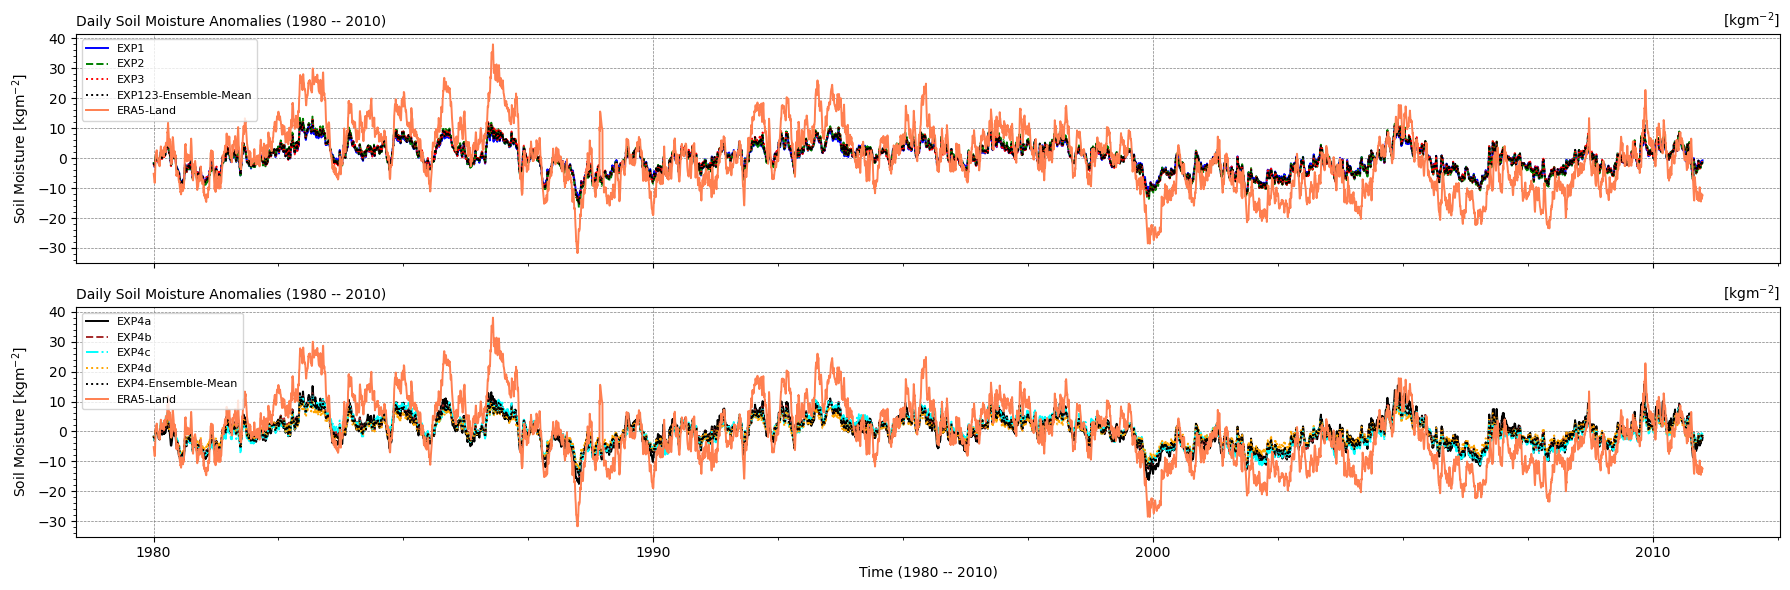

In [10]:
def plot_combined():
    """
    Create a single figure with two subplots (vertical):
    1) Subplot for EXP1, EXP2, EXP3, plus ensemble mean & ERA5
    2) Subplot for EXP4a, 4b, 4c, 4d, plus ensemble mean & ERA5

    Saves the combined figure as 'Combined_Exp123_Exp4_Daily_Ann_SPMIP_Map.pdf'.
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 6), sharex=True)
    ax1, ax2 = axes

    # -------------------------------------------------------------------------
    # SUBPLOT 1: Exp1, Exp2, Exp3, Ensemble123, ERA5
    # -------------------------------------------------------------------------

    ax1.set_title("Daily Soil Moisture Anomalies (1980 -- 2010)", loc='left',
                  fontsize=10, fontweight='regular')
    ax1.set_title("[kgm$^{-2}$]", loc='right', fontsize=10, fontweight='regular')

    ax1.plot(annom_data_CLM5_Exp1.time, exp1_annom, 'b-', linewidth=1.4, label='EXP1')
    ax1.plot(annom_data_CLM5_Exp1.time, exp2_annom, 'g--', linewidth=1.4, label='EXP2')
    ax1.plot(annom_data_CLM5_Exp1.time, exp3_annom, 'r:', linewidth=1.4, label='EXP3')
    ax1.plot(annom_data_CLM5_Exp1.time, Ensemble_mean123_annom, ':', c="black",
             linewidth=1.4, label='EXP123-Ensemble-Mean')
    ax1.plot(annom_data_CLM5_Exp1.time,
             era5_land_annom[:11315].drop("dayofyear"),
             c='coral', linewidth=1.4, label='ERA5-Land')

    ax1.legend(fontsize=8, loc="upper left")
    ax1.set_ylabel("Soil Moisture [kgm$^{-2}$]", fontweight='regular', fontsize=10)

    ax1.minorticks_on()
    ax1.grid(linestyle='--', linewidth=0.5, color='grey')
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)

    # -------------------------------------------------------------------------
    # SUBPLOT 2: Exp4a, 4b, 4c, 4d, Ensemble4, ERA5
    # -------------------------------------------------------------------------

    # We'll reuse the same time axis: annom_data_CLM5_Exp1.time
    ax2.set_title("Daily Soil Moisture Anomalies (1980 -- 2010)", loc='left',
                  fontsize=10, fontweight='regular')
    ax2.set_title("[kgm$^{-2}$]", loc='right', fontsize=10, fontweight='regular')

    ax2.plot(annom_data_CLM5_Exp1.time, exp4a_annom, c='black', linewidth=1.4, label='EXP4a')
    ax2.plot(annom_data_CLM5_Exp1.time, exp4b_annom, '--', c="brown", linewidth=1.4, label='EXP4b')
    ax2.plot(annom_data_CLM5_Exp1.time, exp4c_annom, '-.', c="cyan", linewidth=1.4, label='EXP4c')
    ax2.plot(annom_data_CLM5_Exp1.time, exp4d_annom, ':', c="orange", linewidth=1.4, label='EXP4d')
    ax2.plot(annom_data_CLM5_Exp1.time, Ensemble_mean4_annom,
             ':', c="black", linewidth=1.4, label='EXP4-Ensemble-Mean')
    ax2.plot(annom_data_CLM5_Exp1.time,
             era5_land_annom[:11315].drop("dayofyear"),
             c='coral', linewidth=1.4, label='ERA5-Land')

    ax2.legend(fontsize=8, loc="upper left")
    ax2.set_xlabel("Time (1980 -- 2010)", fontweight='regular', fontsize=10)
    ax2.set_ylabel("Soil Moisture [kgm$^{-2}$]", fontweight='regular', fontsize=10)

    ax2.minorticks_on()
    ax2.grid(linestyle='--', linewidth=0.5, color='grey')
    ax2.tick_params(axis='x', labelsize=10)
    ax2.tick_params(axis='y', labelsize=10)

    # -------------------------------------------------------------------------
    # Finalize and Save
    # -------------------------------------------------------------------------

    fig.tight_layout()
    fig.savefig(f"{figure}/Combined_Exp123_Exp4_Daily_Ann_SPMIP_Map.pdf",
                dpi=1000, bbox_inches='tight')
    plt.show()


# Example usage:
plot_combined()


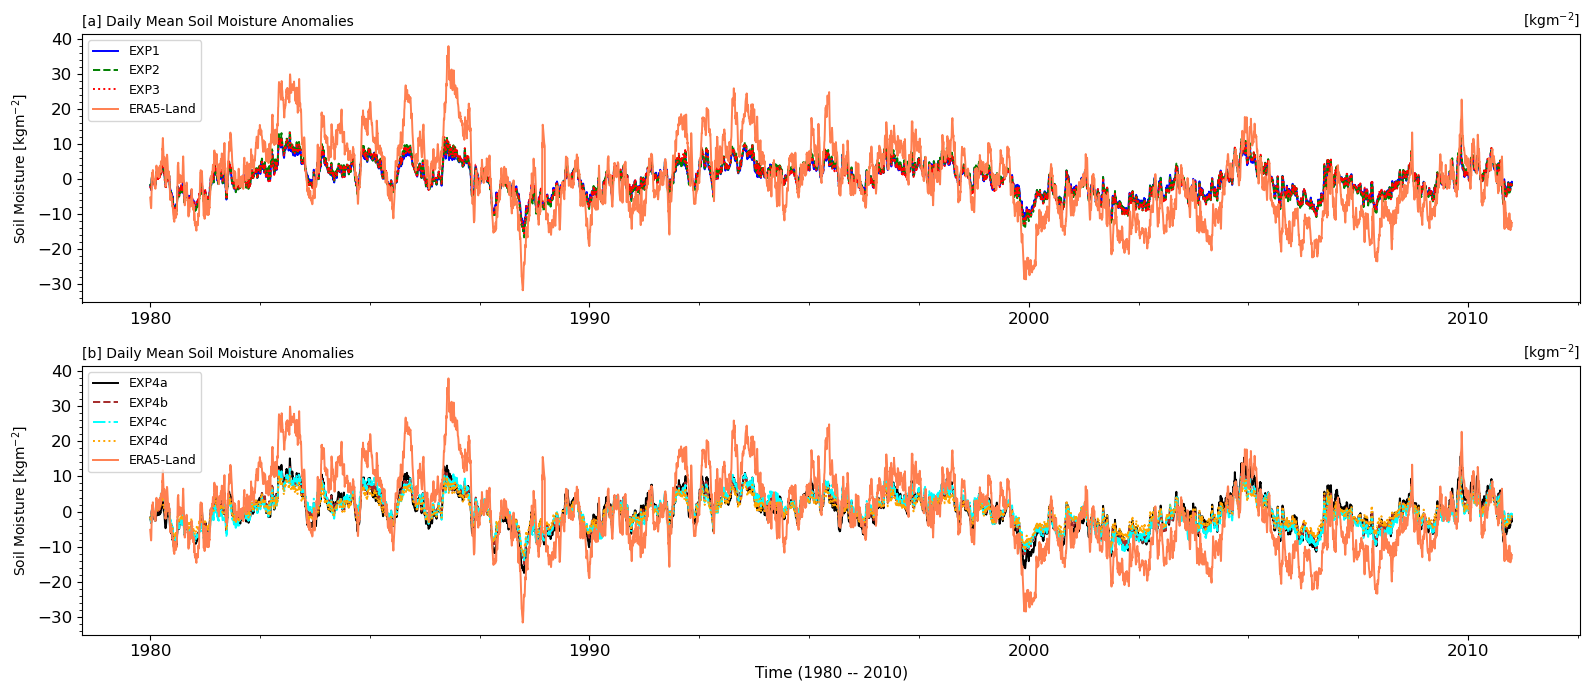

In [11]:
def plot_annomaly_subplot(ax, times, anomalies, labels, colors, linestyles, title, ylabel, xlabel=None):
    ax.set_title(title, fontsize=10, fontweight='regular', loc="left")
    ax.set_title("[kgm$^{-2}$]", fontsize=10, fontweight='regular', loc="right")
    for time, anomaly, label, color, linestyle in zip(times, anomalies, labels, colors, linestyles):
        ax.plot(time, anomaly, label=label, color=color, linestyle=linestyle, linewidth=1.4)
    ax.legend(fontsize=9, loc="upper left")
    if xlabel:  # Only set the xlabel if provided
        ax.set_xlabel(xlabel, fontweight='regular', fontsize=11)
    ax.set_ylabel(ylabel, fontweight='regular', fontsize=10)
    ax.minorticks_on()
    # ax.grid(linestyle='--', linewidth=0.5, color='grey')
    ax.tick_params(axis='both', which='major', labelsize=12)

fig, axs = plt.subplots(2, 1, figsize=(16, 7))  # Creates a figure and two vertical subplots

# Plot for the first set of anomalies without setting xlabel
plot_annomaly_subplot(
    axs[0],
    [annom_data_CLM5_Exp1.time] * 4 + [annom_data_CLM5_Exp1.time],
    [exp1_annom, exp2_annom, exp3_annom, era5_land_annom[:11315].drop("dayofyear")],
    ['EXP1', 'EXP2', 'EXP3', 'ERA5-Land'],
    ['b', 'g', 'r', 'coral'],
    ['-', '--', ':', '-'],
    "[a] Daily Mean Soil Moisture Anomalies",
    "Soil Moisture [kgm$^{-2}$]",
    xlabel=None  # Do not set the xlabel for the first subplot
)

# Plot for the second set of anomalies with xlabel
plot_annomaly_subplot(
    axs[1],
    [annom_data_CLM5_Exp1.time] * 5,
    [exp4a_annom, exp4b_annom, exp4c_annom, exp4d_annom, era5_land_annom[:11315].drop("dayofyear")],
    ['EXP4a', 'EXP4b', 'EXP4c', 'EXP4d', 'ERA5-Land'],
    ['black', 'brown', 'cyan', 'orange', 'coral'],
    ['-', '--', '-.', ':', '-'],
    "[b] Daily Mean Soil Moisture Anomalies",
    "Soil Moisture [kgm$^{-2}$]",
    xlabel="Time (1980 -- 2010)"  # Set the xlabel for the second subplot
)

plt.tight_layout()
plt.savefig(figure+"/Daily_Ann_SPMIP_Map.pdf", dpi=1000, bbox_inches='tight')


# Spatial Plot

In [12]:
def make_contour_plot(data_nc, ax, title,
                      is_first_subplot=False,
                      is_last_row=False):
    """
    Plot a 2D field on a Cartopy GeoAxes with pcolormesh.

    Parameters
    ----------
    data_nc : xarray.DataArray or np.ndarray
        2D array (lat, lon) representing soil moisture or another field.
        'lat' and 'lon' dimensions are assumed if xarray is used.
    ax : cartopy.mpl.geoaxes.GeoAxesSubplot
        Axes on which to plot.
    title : str
        Title for the subplot (displayed on the left).
    is_first_subplot : bool, optional
        If True, sets y-axis (latitude) ticks and labels.
    is_last_row : bool, optional
        If True, sets x-axis (longitude) ticks and labels.

    Returns
    -------
    cs : matplotlib.collections.QuadMesh
        The pcolormesh object for colorbar usage.

    Notes
    -----
    - Adds a cyclic point in longitude for a continuous global map.
    - Applies a 'RdYlBu' colormap, can be changed if desired.
    - Minor decorations (coastlines, borders, etc.) are added.
    """

    # Add a cyclic point to handle 0/360 boundary
    data_cyclic, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)

    # Create filled pcolormesh
    cs = ax.pcolormesh(
        lons2d, lats2d, data_cyclic,
        transform=ccrs.PlateCarree(),
        cmap='RdYlBu',
        shading='auto'
    )

    # Add state/province boundaries
    states = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )
    ax.add_feature(states, edgecolor='gray')

    # Subplot title and color units
    ax.set_title(title, fontweight='regular', fontsize=10, loc='left')
    ax.set_title("kgm$^{-2}$", loc='right', fontweight='regular', size=10)

    # Longitude ticks if this is the last row
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)

    # Latitude ticks if this is the first subplot
    if is_first_subplot:
        ax.set_yticks(np.arange(24, 50, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

    # Minor ticks, coastlines, borders
    ax.minorticks_on()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.add_feature(cfeature.COASTLINE)
    return cs

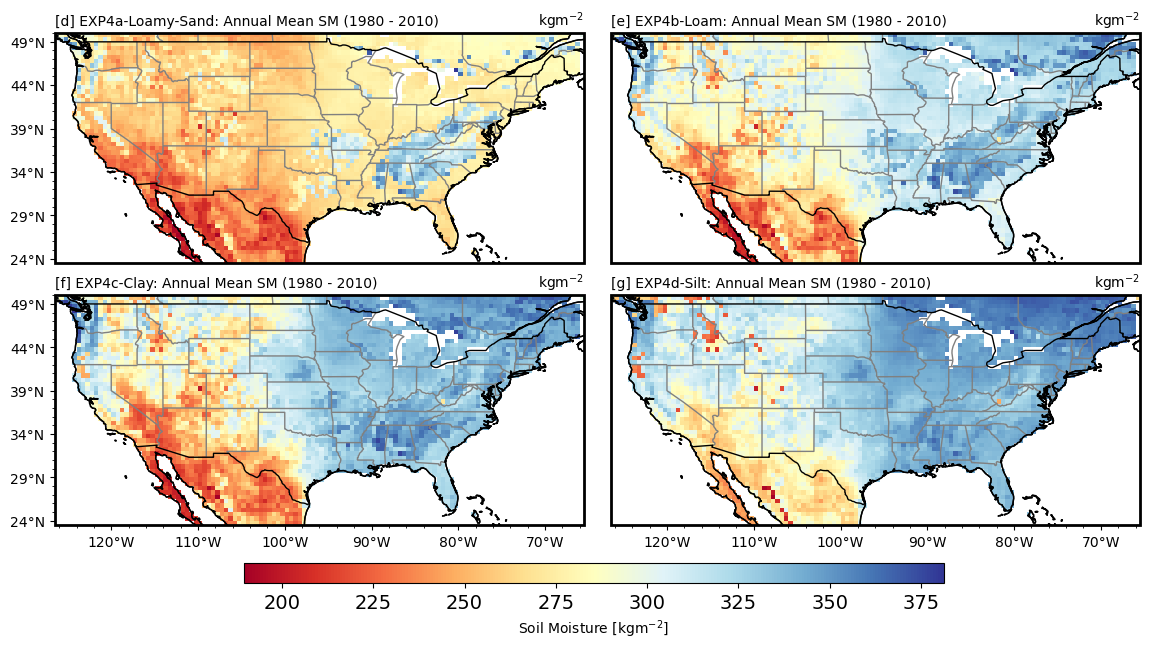

In [13]:
# =========================== FIGURE 1 (EXP4a, 4b, 4c, 4d) ===========================

fig, ax = plt.subplots(
    nrows=2, ncols=2,
    figsize=(14, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': 0.05, 'hspace': -0.12}
)

for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

cs14a_ = make_contour_plot(
    data_CLM5_Exp4a.mean(axis=0) * mask,
    ax=ax[0, 0],
    title='[d] EXP4a-Loamy-Sand: Annual Mean SM (1980 - 2010)',
    is_first_subplot=True
)
cs14b_ = make_contour_plot(
    data_CLM5_Exp4b.mean(axis=0) * mask,
    ax=ax[0, 1],
    title='[e] EXP4b-Loam: Annual Mean SM (1980 - 2010)'
)
cs14c_ = make_contour_plot(
    data_CLM5_Exp4c.mean(axis=0) * mask,
    ax=ax[1, 0],
    title='[f] EXP4c-Clay: Annual Mean SM (1980 - 2010)',
    is_first_subplot=True,
    is_last_row=True
)
cs14d_ = make_contour_plot(
    data_CLM5_Exp4d.mean(axis=0) * mask,
    ax=ax[1, 1],
    title='[g] EXP4d-Silt: Annual Mean SM (1980 - 2010)',
    is_last_row=True
)

# Adjust spacing for colorbar
fig.subplots_adjust(bottom=0.2, top=0.9)
# Colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5, 0.025])  # left, bottom, width, height
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=10)

plt.savefig(f"{figure}/Exp4TotalSM_SPMIP_Map.pdf", dpi=600, bbox_inches='tight')

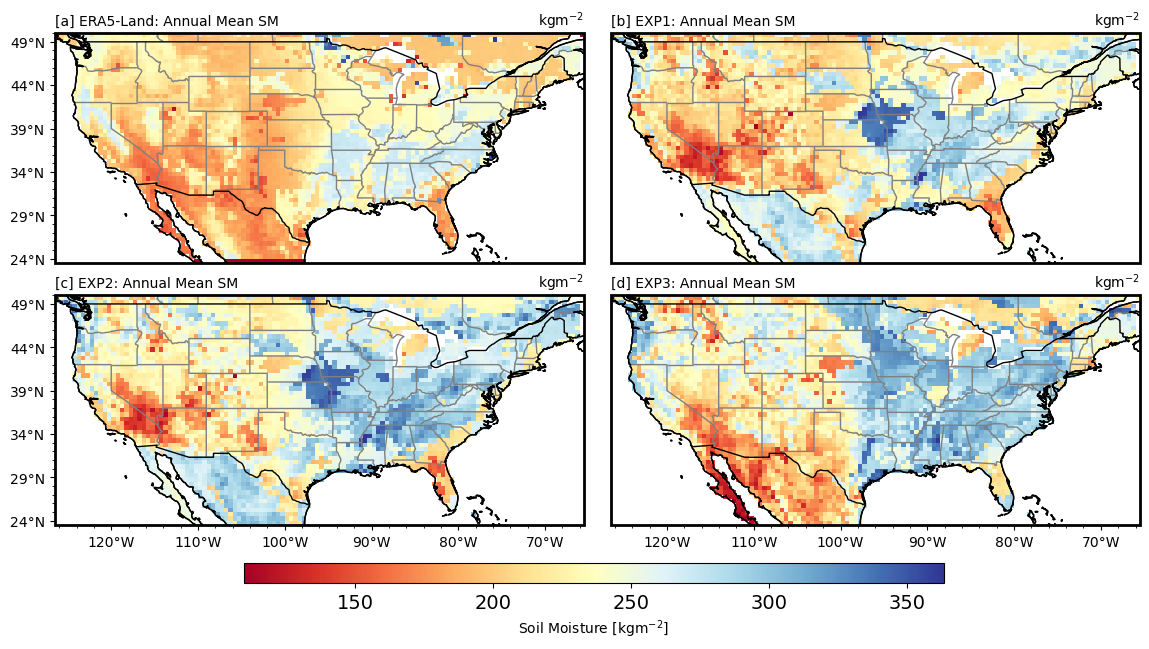

In [14]:
# =========================== FIGURE 2 (ERA5, EXP1, EXP2, EXP3) ===========================

fig, ax = plt.subplots(
    nrows=2, ncols=2,
    figsize=(14, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': 0.05, 'hspace': -0.12}
)

for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

cs1e = make_contour_plot(
    ERA5_land_mean * mask,
    ax=ax[0, 0],
    title='[a] ERA5-Land: Annual Mean SM',
    is_first_subplot=True
)
cs11_ = make_contour_plot(
    data_CLM5_Exp1.mean(axis=0) * mask,
    ax=ax[0, 1],
    title='[b] EXP1: Annual Mean SM'
)
cs12_ = make_contour_plot(
    data_CLM5_Exp2.mean(axis=0) * mask,
    ax=ax[1, 0],
    title='[c] EXP2: Annual Mean SM',
    is_first_subplot=True,
    is_last_row=True
)
cs13_ = make_contour_plot(
    data_CLM5_Exp3.mean(axis=0) * mask,
    ax=ax[1, 1],
    title='[d] EXP3: Annual Mean SM',
    is_last_row=True
)

fig.subplots_adjust(bottom=0.2, top=0.9)
cbar_ax = fig.add_axes([0.26, 0.17, 0.5, 0.025])
cbar = fig.colorbar(cs11_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=10)

plt.savefig(f"{figure}/exp123.pdf", dpi=600, bbox_inches='tight')
plt.show()


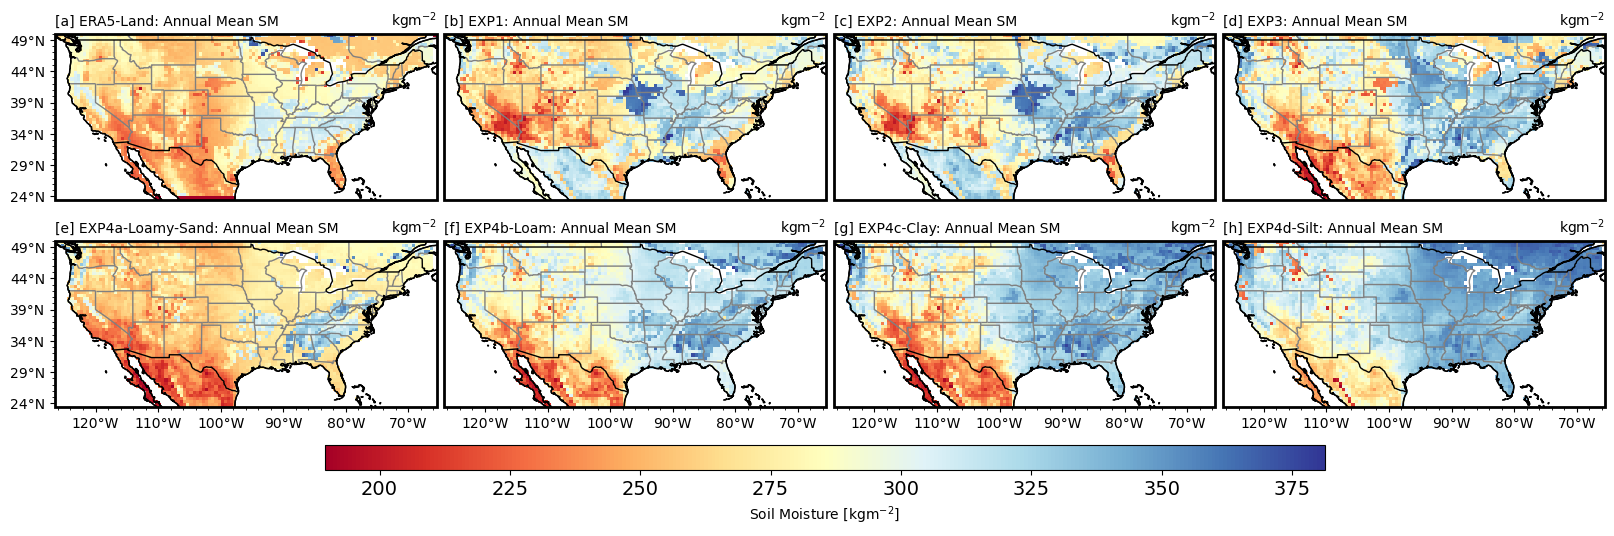

In [15]:
fig, ax = plt.subplots(
    nrows=2, ncols=4, figsize=[20, 10],
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': 0.02, 'hspace': -0.58}  
)

for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')  # Set border color to black
    axis.spines['geo'].set_linewidth(2)        # Set border width

# === Spatial Maps === #
# Row 1: ERA5-Land and Experimental Mean Soil Moisture
cs1e = make_contour_plot(
    ERA5_land_mean * mask, ax[0, 0], '[a] ERA5-Land: Annual Mean SM', is_first_subplot=True
)
cs11_ = make_contour_plot(
    data_CLM5_Exp1.mean(axis=0) * mask, ax[0, 1], '[b] EXP1: Annual Mean SM'
)
cs12_ = make_contour_plot(
    data_CLM5_Exp2.mean(axis=0) * mask, ax[0, 2], '[c] EXP2: Annual Mean SM'
)
cs13_ = make_contour_plot(
    data_CLM5_Exp3.mean(axis=0) * mask, ax[0, 3], '[d] EXP3: Annual Mean SM'
)

# Row 2: Experimental Variations with Soil Types
cs14a_ = make_contour_plot(
    data_CLM5_Exp4a.mean(axis=0) * mask, ax[1, 0],
    '[e] EXP4a-Loamy-Sand: Annual Mean SM', is_first_subplot=True, is_last_row=True
)
cs14b_ = make_contour_plot(
    data_CLM5_Exp4b.mean(axis=0) * mask, ax[1, 1],
    '[f] EXP4b-Loam: Annual Mean SM', is_last_row=True
)
cs14c_ = make_contour_plot(
    data_CLM5_Exp4c.mean(axis=0) * mask, ax[1, 2],
    '[g] EXP4c-Clay: Annual Mean SM', is_last_row=True
)
cs14d_ = make_contour_plot(
    data_CLM5_Exp4d.mean(axis=0) * mask, ax[1, 3],
    '[h] EXP4d-Silt: Annual Mean SM', is_last_row=True
)

fig.subplots_adjust(bottom=0.2, top=0.9)  
cbar_ax = fig.add_axes([0.26, 0.3, 0.5, 0.025])  
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal') 
cbar.ax.tick_params(labelsize=14)  # Set tick label size
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=10) 

plt.savefig(figure + "/b_ERA5_SM_Comp.pdf", dpi=600, bbox_inches='tight')


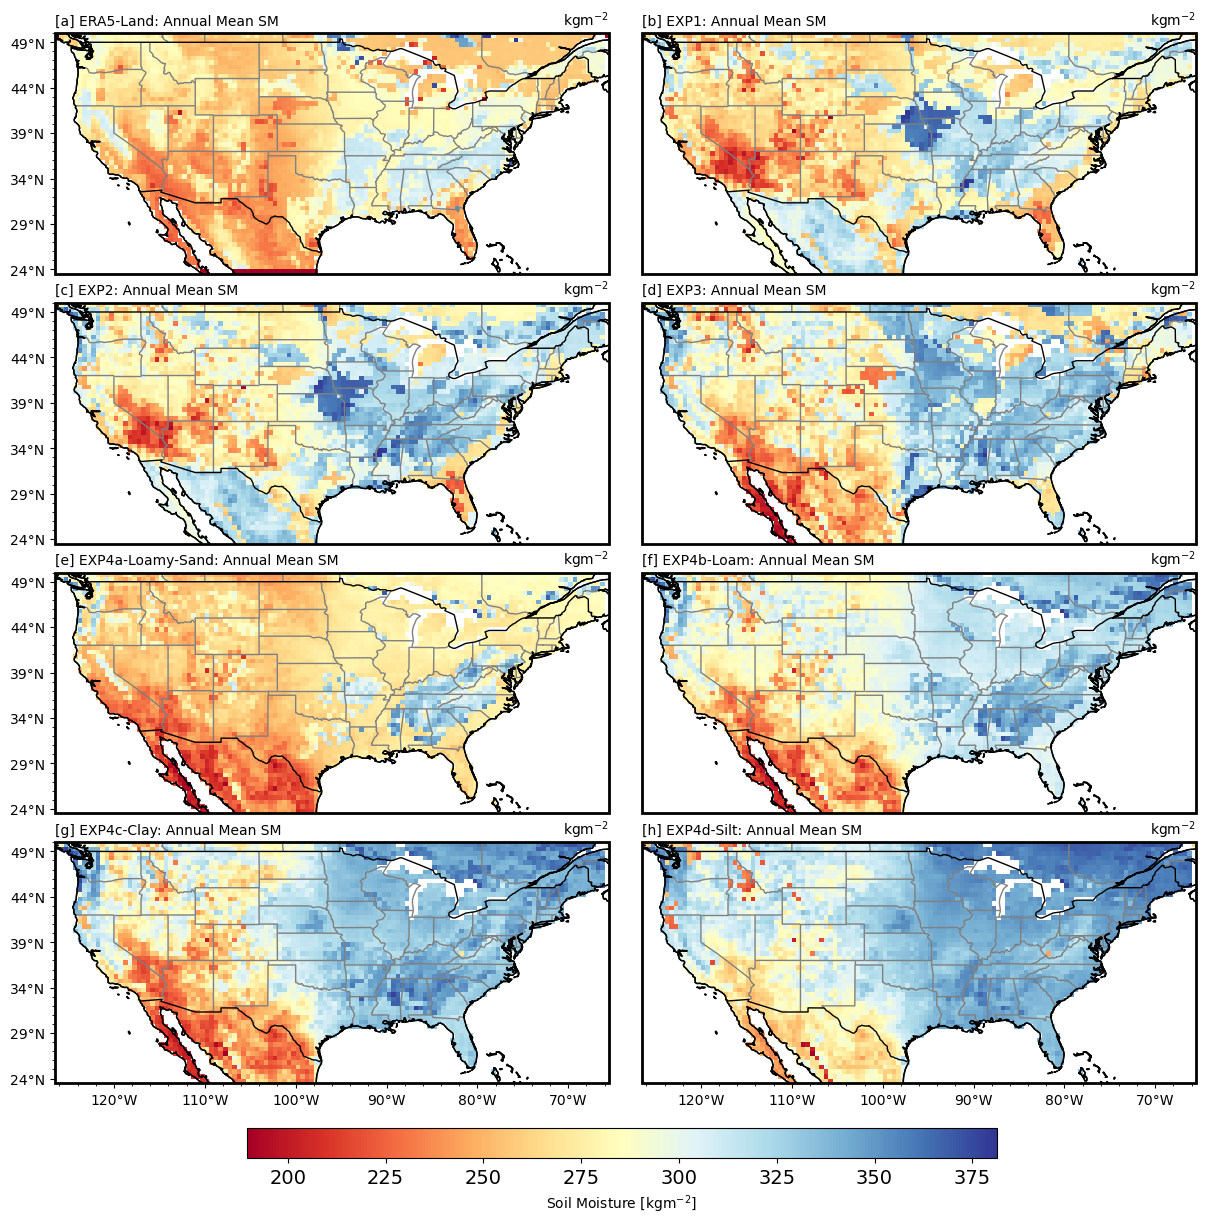

In [16]:
fig, ax = plt.subplots(
    nrows=4, ncols=2, figsize=[15, 15],
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': 0.02, 'hspace': 0.12}  # Adjust spacing between subplots
)

# Customize geographic axes: add borders with specific colors and widths
for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')  # Set border color to black
    axis.spines['geo'].set_linewidth(2)        # Set border width

# === Spatial Maps === #
#----------- First row: ERA5-Land and EXP1
cs1e = make_contour_plot(
    ERA5_land_mean * mask, ax[0, 0], '[a] ERA5-Land: Annual Mean SM', is_first_subplot=True
)
cs11_ = make_contour_plot(
    data_CLM5_Exp1.mean(axis=0) * mask, ax[0, 1], '[b] EXP1: Annual Mean SM'
)

#----------- Second row: EXP2 and EXP3
cs12_ = make_contour_plot(
    data_CLM5_Exp2.mean(axis=0) * mask, ax[1, 0], '[c] EXP2: Annual Mean SM', is_first_subplot=True
)
cs13_ = make_contour_plot(
    data_CLM5_Exp3.mean(axis=0) * mask, ax[1, 1], '[d] EXP3: Annual Mean SM'
)

#----------- Third row: EXP4a and EXP4b
cs14a_ = make_contour_plot(
    data_CLM5_Exp4a.mean(axis=0) * mask, ax[2, 0], '[e] EXP4a-Loamy-Sand: Annual Mean SM', is_first_subplot=True
)
cs14b_ = make_contour_plot(
    data_CLM5_Exp4b.mean(axis=0) * mask, ax[2, 1], '[f] EXP4b-Loam: Annual Mean SM'
)

#----------- Fourth row: EXP4c and EXP4d
cs14c_ = make_contour_plot(
    data_CLM5_Exp4c.mean(axis=0) * mask, ax[3, 0],
    '[g] EXP4c-Clay: Annual Mean SM', is_first_subplot=True, is_last_row=True
)
cs14d_ = make_contour_plot(
    data_CLM5_Exp4d.mean(axis=0) * mask, ax[3, 1],
    '[h] EXP4d-Silt: Annual Mean SM', is_last_row=True
)

fig.subplots_adjust(bottom=0.2, top=0.9)  
cbar_ax = fig.add_axes([0.26, 0.15, 0.5, 0.02])  
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal') 
cbar.ax.tick_params(labelsize=14)  # Set tick label size
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=10) 

# Save the figure as a high-resolution PDF
plt.savefig(figure + "/ERA5_SM_Comp.pdf", dpi=600, bbox_inches='tight')


In [17]:
def _make_contour_plot_(data_nc, ax, title, is_first_subplot=False, is_last_row=False):
    """
    Create a filled contour plot on a given axis.

    Args:
        data_nc (xarray.DataArray or ndarray): Input data to be plotted.
        ax (matplotlib.axes._axes.Axes): Axis object for the subplot.
        title (str): Title for the subplot.
        is_first_subplot (bool, optional): Flag for the first subplot. Adds latitude ticks.
        is_last_row (bool, optional): Flag for the last row of subplots. Adds longitude ticks.

    Returns:
        QuadContourSet: Contour plot object.
    """
    # Add cyclic point for seamless plotting across the 0-degree longitude
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])

    # Create a filled contour plot
    cs = ax.contourf(
        lons, data_nc['lat'], data, transform=ccrs.PlateCarree(),
        cmap='RdYlBu', extend='both'
    )
    
    # Add state boundaries
    states = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )
    ax.add_feature(states, edgecolor='gray')
    ax.set_title(title, fontweight='regular', fontsize=10, loc='left')

    # Add latitude ticks for the first subplot
    if is_first_subplot:
        ax.set_yticks(np.arange(24, 50, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
    
    # Add longitude ticks for the last row of subplots
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)

    # Additional features
    ax.minorticks_on()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.add_feature(cfeature.COASTLINE)

    return cs

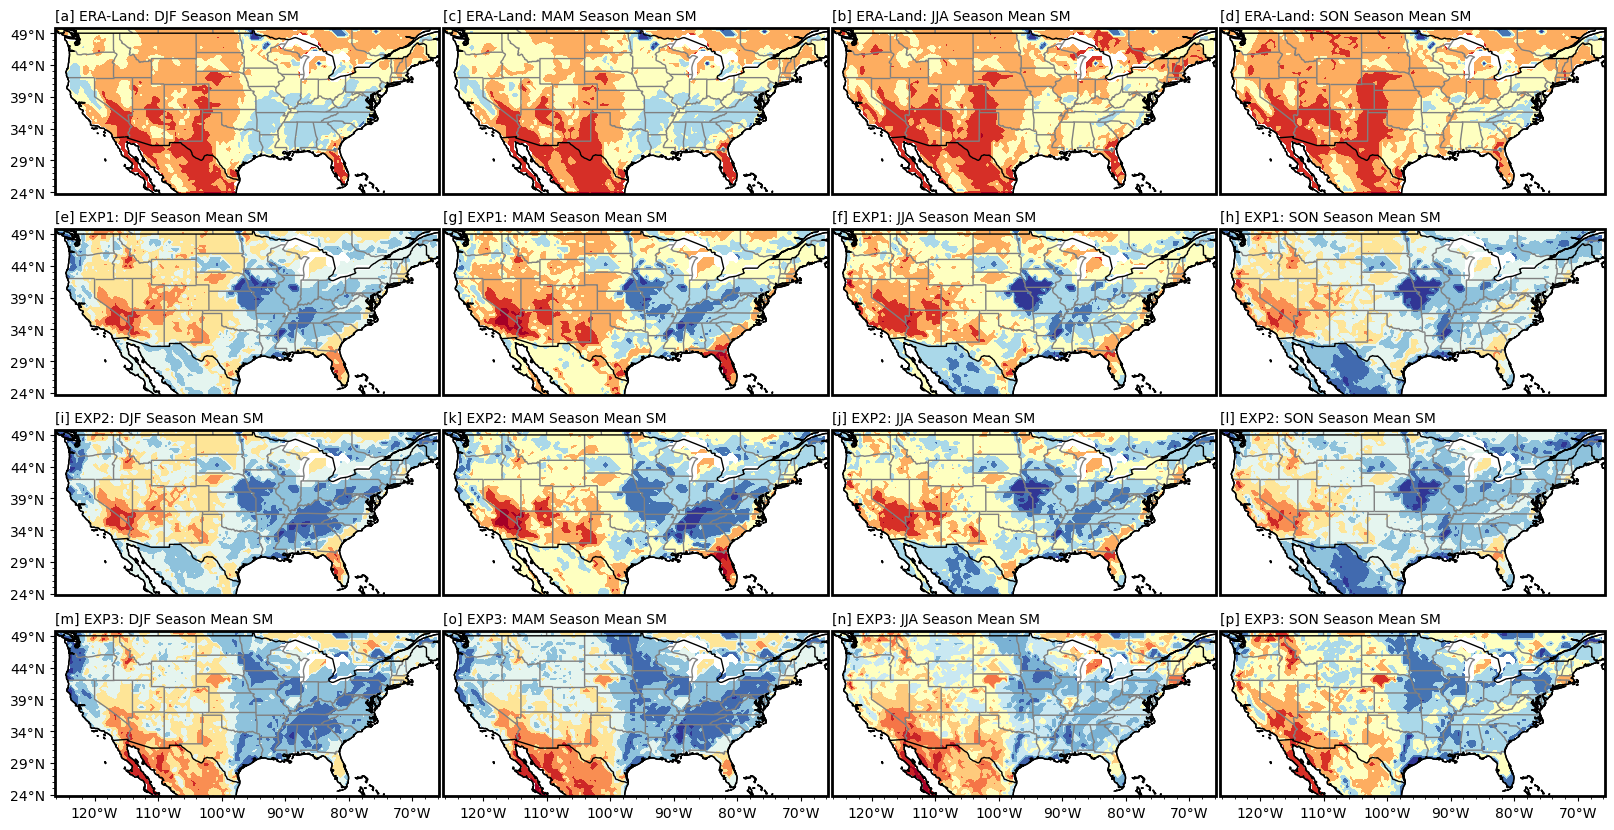

In [18]:
nfig, ax = plt.subplots(
    nrows=4, ncols=4, figsize=[20, 10],
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': 0.01, 'hspace': 0.2}  # Adjust spacing between subplots
)

#-------------- Customize subplot appearance
for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')  
    axis.spines['geo'].set_linewidth(2)        

# === Spatial Maps for Seasonal Data === #
#-------------- Plot seasonal data for ERA5-Land
cserDJF_ = _make_contour_plot_(
    data_ERA5_seas[0, :, :], ax[0, 0], '[a] ERA-Land: DJF Season Mean SM', is_first_subplot=True
)
cserJJA_ = _make_contour_plot_(
    data_ERA5_seas[1, :, :], ax[0, 2], '[b] ERA-Land: JJA Season Mean SM'
)
cserMAM_ = _make_contour_plot_(
    data_ERA5_seas[2, :, :], ax[0, 1], '[c] ERA-Land: MAM Season Mean SM'
)
cserSON_ = _make_contour_plot_(
    data_ERA5_seas[3, :, :], ax[0, 3], '[d] ERA-Land: SON Season Mean SM'
)

#-------------- Plot seasonal data for EXP1
cs1DJF_ = _make_contour_plot_(
    data_CLM5_Exp1_seas[0, :, :], ax[1, 0], '[e] EXP1: DJF Season Mean SM', is_first_subplot=True
)
cs1JJA_ = _make_contour_plot_(
    data_CLM5_Exp1_seas[1, :, :], ax[1, 2], '[f] EXP1: JJA Season Mean SM'
)
cs1MAM_ = _make_contour_plot_(
    data_CLM5_Exp1_seas[2, :, :], ax[1, 1], '[g] EXP1: MAM Season Mean SM'
)
cs1SON_ = _make_contour_plot_(
    data_CLM5_Exp1_seas[3, :, :], ax[1, 3], '[h] EXP1: SON Season Mean SM'
)

#-------------- Plot seasonal data for EXP2
cs2DJF_ = _make_contour_plot_(
    data_CLM5_Exp2_seas[0, :, :], ax[2, 0], '[i] EXP2: DJF Season Mean SM', is_first_subplot=True
)
cs2JJA_ = _make_contour_plot_(
    data_CLM5_Exp2_seas[1, :, :], ax[2, 2], '[j] EXP2: JJA Season Mean SM'
)
cs2MAM_ = _make_contour_plot_(
    data_CLM5_Exp2_seas[2, :, :], ax[2, 1], '[k] EXP2: MAM Season Mean SM'
)
cs2SON_ = _make_contour_plot_(
    data_CLM5_Exp2_seas[3, :, :], ax[2, 3], '[l] EXP2: SON Season Mean SM'
)

#-------------- Plot seasonal data for EXP3
cs3DJF_ = _make_contour_plot_(
    data_CLM5_Exp3_seas[0, :, :], ax[3, 0], '[m] EXP3: DJF Season Mean SM', is_first_subplot=True, is_last_row=True
)
cs3JJA_ = _make_contour_plot_(
    data_CLM5_Exp3_seas[1, :, :], ax[3, 2], '[n] EXP3: JJA Season Mean SM', is_last_row=True
)
cs3MAM_ = _make_contour_plot_(
    data_CLM5_Exp3_seas[2, :, :], ax[3, 1], '[o] EXP3: MAM Season Mean SM', is_last_row=True
)
cs3SON_ = _make_contour_plot_(
    data_CLM5_Exp3_seas[3, :, :], ax[3, 3], '[p] EXP3: SON Season Mean SM', is_last_row=True
)

fig.subplots_adjust(bottom=0.2, top=0.9)  
cbar_ax = fig.add_axes([0.26, 0.129, 0.5, 0.025]) 
cbar = fig.colorbar(cs3SON_, cax=cbar_ax, orientation='horizontal') 
cbar.ax.tick_params(labelsize=14)  # Set tick label size
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=12) 
plt.savefig(figure + "/Seas123TotalSM_SPMIP_Map.pdf", dpi=1000, bbox_inches='tight')


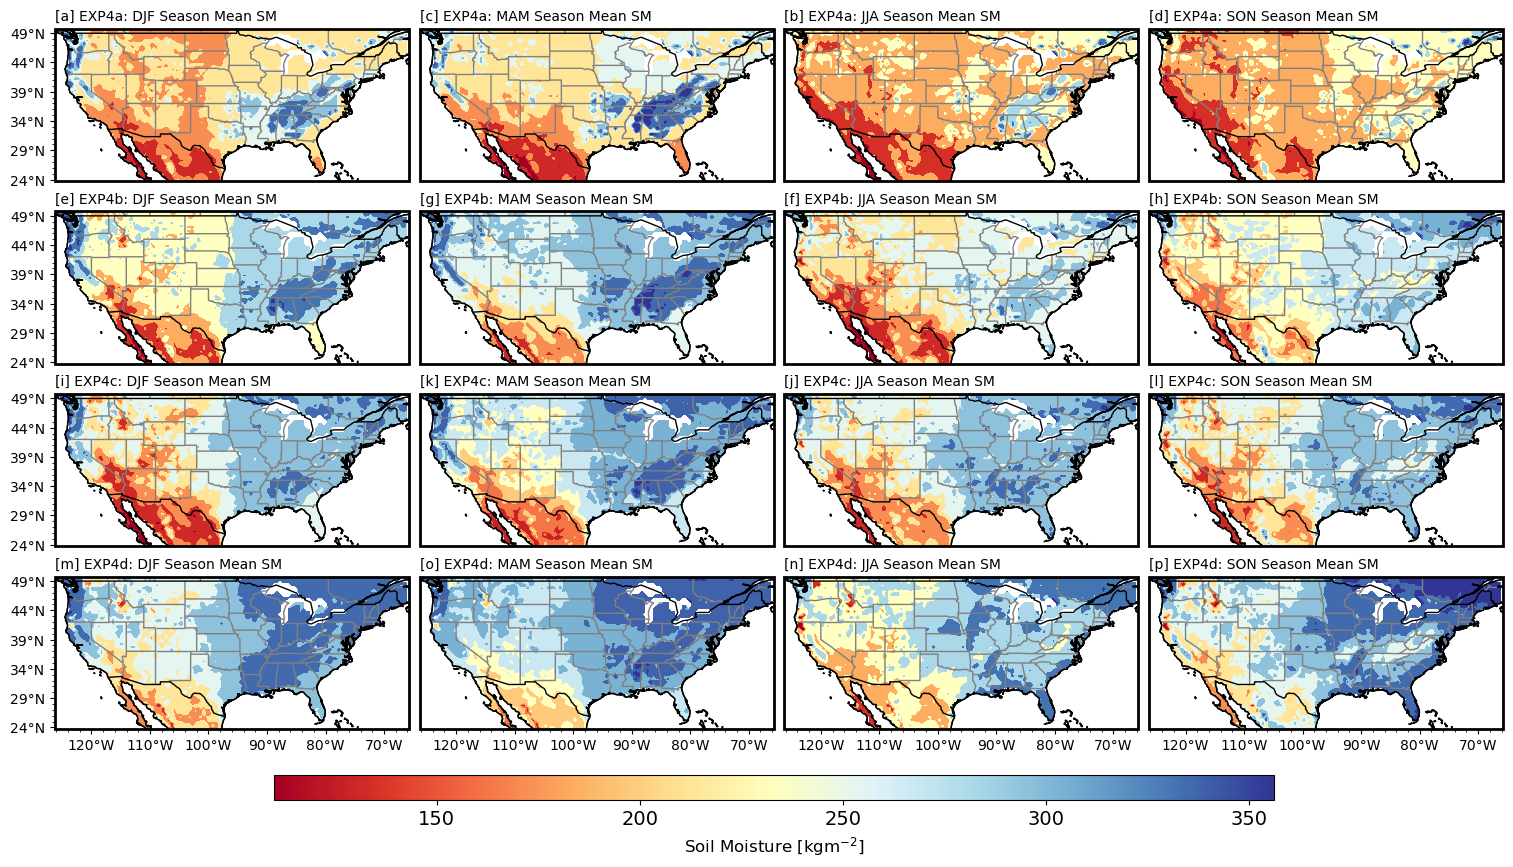

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[20, 10],
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'wspace': -0.2, 'hspace': 0.2})
for axis in ax.flat:
    # Set the border color and width
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

cs4aDJF_ = _make_contour_plot_(data_CLM5_Exp4a_seas[0,:,:],  ax[0,0], '[a] EXP4a: DJF Season Mean SM', is_first_subplot=True)
cs4aJJA_ = _make_contour_plot_(data_CLM5_Exp4a_seas[1,:,:] , ax[0,2], '[b] EXP4a: JJA Season Mean SM')
cs4aMAM_ = _make_contour_plot_(data_CLM5_Exp4a_seas[2,:,:],  ax[0,1], '[c] EXP4a: MAM Season Mean SM')
cs4aSON_ = _make_contour_plot_(data_CLM5_Exp4a_seas[3,:,:],  ax[0,3], '[d] EXP4a: SON Season Mean SM')

cs4bDJF_ = _make_contour_plot_(data_CLM5_Exp4b_seas[0,:,:],  ax[1,0], '[e] EXP4b: DJF Season Mean SM', is_first_subplot=True)
cs4bJJA_ = _make_contour_plot_(data_CLM5_Exp4b_seas[1,:,:] , ax[1,2], '[f] EXP4b: JJA Season Mean SM')
cs4bMAM_ = _make_contour_plot_(data_CLM5_Exp4b_seas[2,:,:],  ax[1,1], '[g] EXP4b: MAM Season Mean SM')
cs4bSON_ = _make_contour_plot_(data_CLM5_Exp4b_seas[3,:,:],  ax[1,3], '[h] EXP4b: SON Season Mean SM')

cs4cDJF_ = _make_contour_plot_(data_CLM5_Exp4c_seas[0,:,:],  ax[2,0], '[i] EXP4c: DJF Season Mean SM', is_first_subplot=True)
cs4cJJA_ = _make_contour_plot_(data_CLM5_Exp4c_seas[1,:,:] , ax[2,2], '[j] EXP4c: JJA Season Mean SM')
cs4cMAM_ = _make_contour_plot_(data_CLM5_Exp4c_seas[2,:,:],  ax[2,1], '[k] EXP4c: MAM Season Mean SM')
cs4cSON_ = _make_contour_plot_(data_CLM5_Exp4c_seas[3,:,:],  ax[2,3], '[l] EXP4c: SON Season Mean SM')

cs4dDJF_ = _make_contour_plot_(data_CLM5_Exp4d_seas[0,:,:],  ax[3,0], '[m] EXP4d: DJF Season Mean SM', is_first_subplot=True, is_last_row=True)
cs4dJJA_ = _make_contour_plot_(data_CLM5_Exp4d_seas[1,:,:] , ax[3,2], '[n] EXP4d: JJA Season Mean SM', is_last_row=True)
cs4dMAM_ = _make_contour_plot_(data_CLM5_Exp4d_seas[2,:,:],  ax[3,1], '[o] EXP4d: MAM Season Mean SM', is_last_row=True)
cs4dSON_ = _make_contour_plot_(data_CLM5_Exp4d_seas[3,:,:],  ax[3,3], '[p] EXP4d: SON Season Mean SM', is_last_row=True)

# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.129, 0.5, 0.025])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs13_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=12)
plt.savefig(figure+"/Seas4TotalSM_SPMIP_Map.pdf", dpi = 1000, bbox_inches='tight')